In [25]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os
import numpy as np

import dash
from dash import dcc, html, Input, Output
from dash import dash_table
import plotly.graph_objs as go
# Conectar a la base de datos y cargar los datos
conn = sqlite3.connect("../../db/proyectomacro.db")
df = pd.read_sql("SELECT * FROM exportaciones_minerales_totales", conn)
df2 = pd.read_sql("SELECT * FROM precio_oficial_minerales", conn)
df.set_index('año', inplace=True)
df.index = df.index.astype(int)
conn.close()

df2.set_index('año', inplace=True)
df2.index = df2.index.astype(int)
df2 = df2.loc[1956:2023]
conn.close()
# Calcular el precio efectivo para cada mineral
minerales_lista = ["estaño", "plomo", "zinc", "plata", "wolfram", "cobre", "antimonio", "oro"]
# Fórmula: precio_efectivo = (valor * 1000) / volumen
df['estaño_precio_efectivo']   = (df['estaño_valor']   * 1000) / df['estaño_volumen']
df['plomo_precio_efectivo']    = (df['plomo_valor']    * 1000) / df['plomo_volumen']
df['zinc_precio_efectivo']     = (df['zinc_valor']     * 1000) / df['zinc_volumen']
df['plata_precio_efectivo']    = (df['plata_valor']    * 1000) / df['plata_volumen']
df['wolfram_precio_efectivo']  = (df['wolfram_valor']  * 1000) / df['wolfram_volumen']
df['antimonio_precio_efectivo']= (df['antimonio_valor']* 1000) / df['antimonio_volumen']
df['oro_precio_efectivo']      = (df['oro_valor']      * 1000) / df['oro_volumen']

for mineral in minerales_lista:
    vol_col = f"{mineral}_volumen"
    val_col = f"{mineral}_valor"
    precio_efectivo_col = f"{mineral}_precio_efectivo"
    # Convertir el valor de exportación (miles de USD a USD) y dividir por el volumen
    df[precio_efectivo_col] = (df[val_col] * 1000) / df[vol_col]

df2.head()

,zinc,estaño,oro,plata,antimonio,plomo,wolfram,cobre,bismuto,cadmio,manganeso
año,,,,,,,,,,,
1956,0.1350,1.000,NaN,0.9000,314.91,0.16,25.000,0.3800,1.30,NaN,NaN
1957,0.1050,0.920,NaN,0.9000,223.42,0.13,10.370,0.2600,1.45,NaN,NaN
1958,0.1100,0.990,NaN,0.9000,265.71,0.13,10.000,0.2900,1.45,NaN,NaN
1959,0.1125,1.019,NaN,0.9067,300.16,0.12,10.625,0.2825,1.45,NaN,NaN
1960,0.1130,1.010,NaN,0.9100,305.07,0.12,16.830,0.3000,1.45,NaN,NaN


In [26]:
df_period1 = df.loc[df.index <= 2005]
df_period2 = df.loc[df.index >= 2006]
df2_period1 = df2.loc[df2.index <= 2005]
df2_period2 = df2.loc[df2.index >= 2006]

def calc_contribuciones(df,mineral):
    vol_col = f"{mineral}_volumen"
    precio_efectivo_col = f"{mineral}_precio_efectivo"
    valor_col = f"{mineral}_valor"  # valor exportado en miles de USD
    min_year = df.index.min()
    max_year = df.index.max()
    revenue_first = df.loc[min_year, valor_col] * 1000
    revenue_last  = df.loc[max_year, valor_col] * 1000
    delta_log_revenue = np.log(revenue_last) - np.log(revenue_first)

    print(delta_log_revenue)
    price_first = df.loc[min_year, precio_efectivo_col]
    price_last  = df.loc[max_year, precio_efectivo_col]
    delta_log_price = np.log(price_last) - np.log(price_first)

    volume_first = df.loc[min_year, vol_col]
    volume_last  = df.loc[max_year, vol_col]
    delta_log_volume = np.log(volume_last) - np.log(volume_first)


    if delta_log_revenue != 0:
        price_contrib = (delta_log_price / delta_log_revenue) * 100
        print(f'precio {mineral}:{price_contrib}')
        volume_contrib = (delta_log_volume / delta_log_revenue) * 100
        print(f'volumen {mineral}:{volume_contrib}')
        return(price_contrib,volume_contrib)
    else:
        price_contrib, volume_contrib = 0, 0

In [27]:


# Definir carpeta de salida para las imágenes
output_dir = "../../assets/imagenes/15.exportaciones_minerales"
os.makedirs(output_dir, exist_ok=True)



# Para cada mineral, generar 2 gráficas:
#   1) Dual Axis: Volumen (desde df) vs Precio Oficial (desde df2)
#   2) Precio Efectivo (calculado en df)
def dual_axis_grafica(df,df2,mineral):
    vol_col = f"{mineral}_volumen"
    precio_efectivo_col = f"{mineral}_precio_efectivo"
    # En df2, la columna oficial se llama igual que el mineral (ya en snake_case y con la tilde corregida)
    precio_oficial_col = mineral

    promedio_precio_neolib=df2_period1[mineral].mean()
    promedio_precio_eco_plural=df2_period2[mineral].mean()

    promedio_vol_neolib=df_period1[vol_col].mean()
    promedio_vol_eco_plural=df_period2[vol_col].mean()
    # 1) Gráfica Dual Axis: Volumen vs Precio Oficial
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # Graficar el volumen exportado
    ax1.plot(df.index, df[vol_col], marker='o', linestyle='-', color='tab:blue', label="Volumen")
    ax1.set_ylabel("Volumen (kilos finos)", color='tab:blue', fontsize=14)
    
    # Graficar el precio oficial (usando df2)
    # Es importante que ambos DataFrames estén alineados por año
    ax2.plot(df2.index, df2[precio_oficial_col], marker='s', linestyle='-', color='tab:red', label="Precio Oficial")
    ax2.set_ylabel("Precio Oficial (USD)", color='tab:red', fontsize=14)
    
    ax1.set_xlabel("Año", fontsize=14)
    plt.title(f"{mineral.capitalize()}: Volumen vs Precio Oficial", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xticks(df.index)
    ax1.set_xticklabels(df.index, rotation=45)
    fig.tight_layout()
    return(fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural)
def precio_efectivo_grafica(df,mineral):
    # 2) Gráfica de Precio Efectivo
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[precio_efectivo_col], marker='P', linestyle='-', color='tab:green')
    plt.title(f"{mineral.capitalize()}: Precio Efectivo", fontsize=16)
    plt.xlabel("Año", fontsize=14)
    plt.ylabel("Precio Efectivo (USD por unidad)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(df.index, rotation=45)
    plt.tight_layout()
    return(plt)


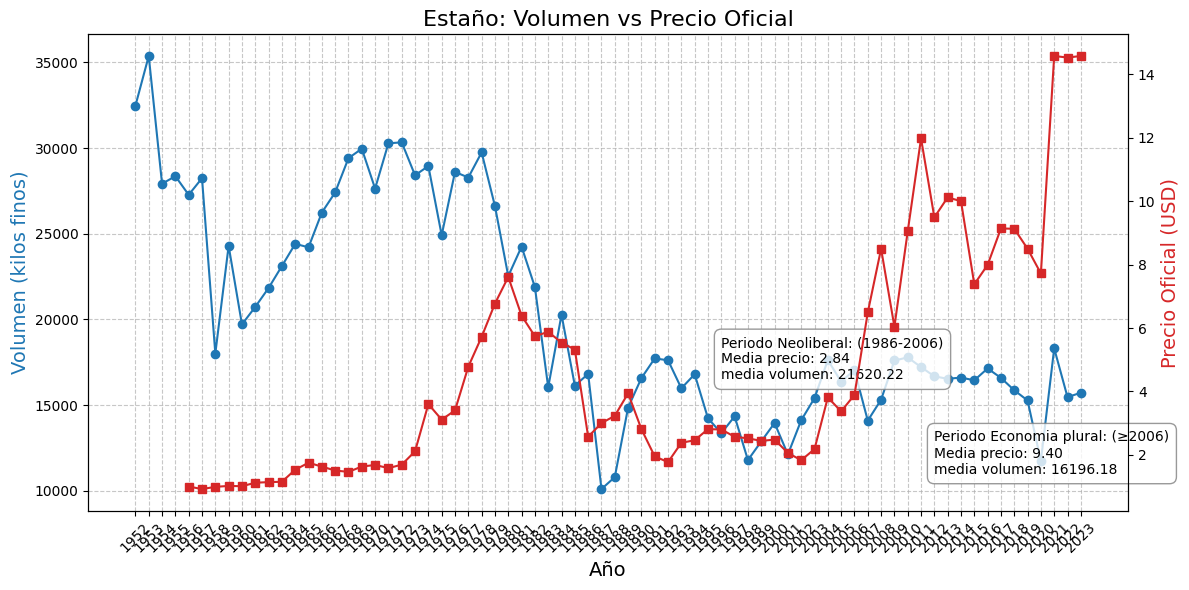

In [28]:
mineral="estaño"

fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1996, 16500,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 11000,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
filename_dual = os.path.join(output_dir, f"15.1.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)   # Guardar la figura
plt.show()                            # Mostrarla en pantalla
plt.close(fig)     

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.1.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

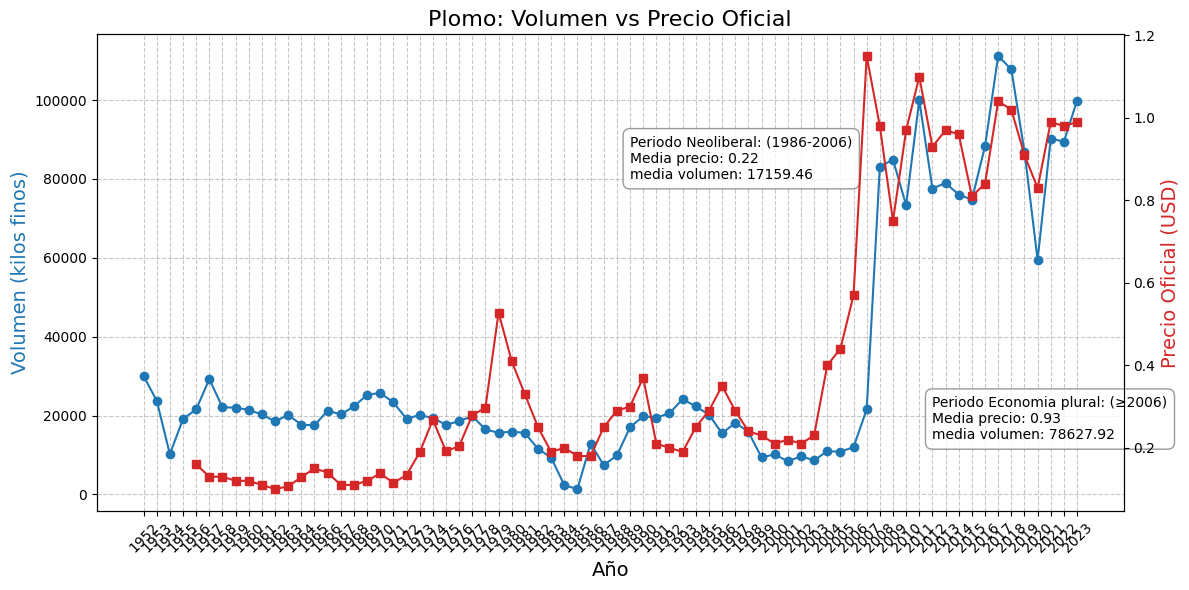

In [29]:
mineral="plomo"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1989, 80000,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 14000,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.2.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.2.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

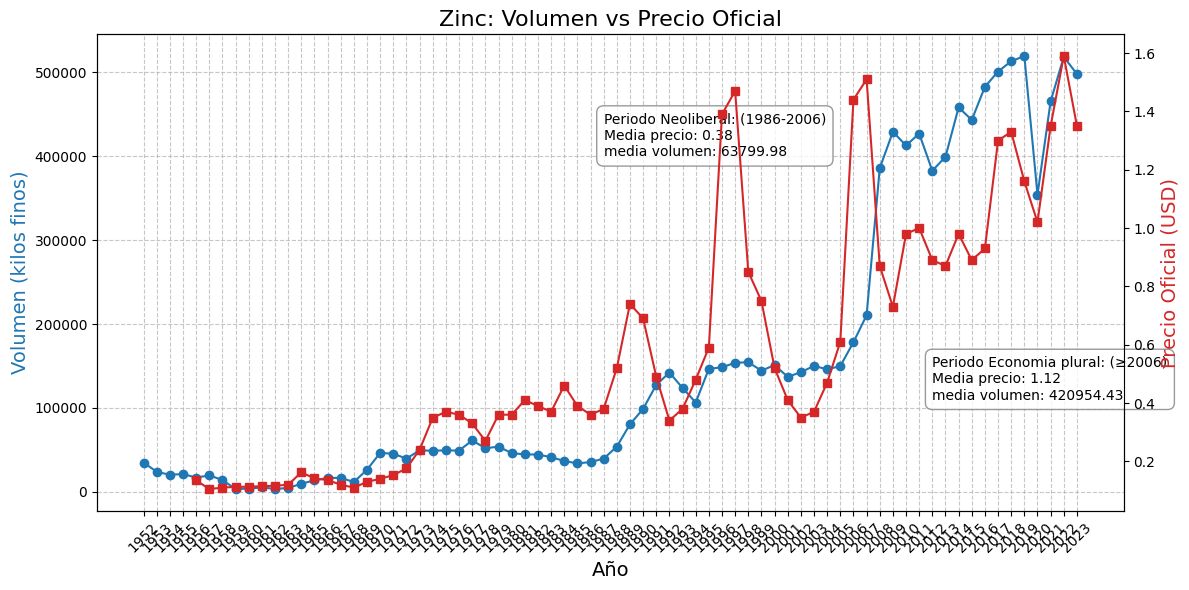

In [30]:
mineral="zinc"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1987, 400000,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 110000,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.3.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.3.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

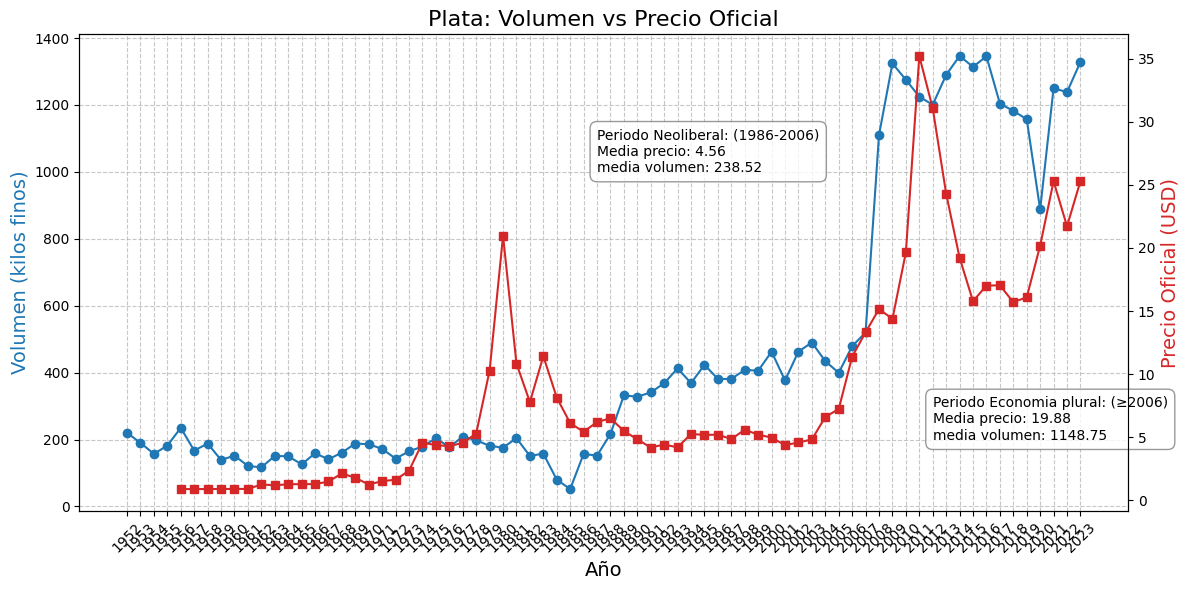

In [31]:
mineral="plata"
fig,ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1987, 1000,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 200,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.4.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.4.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

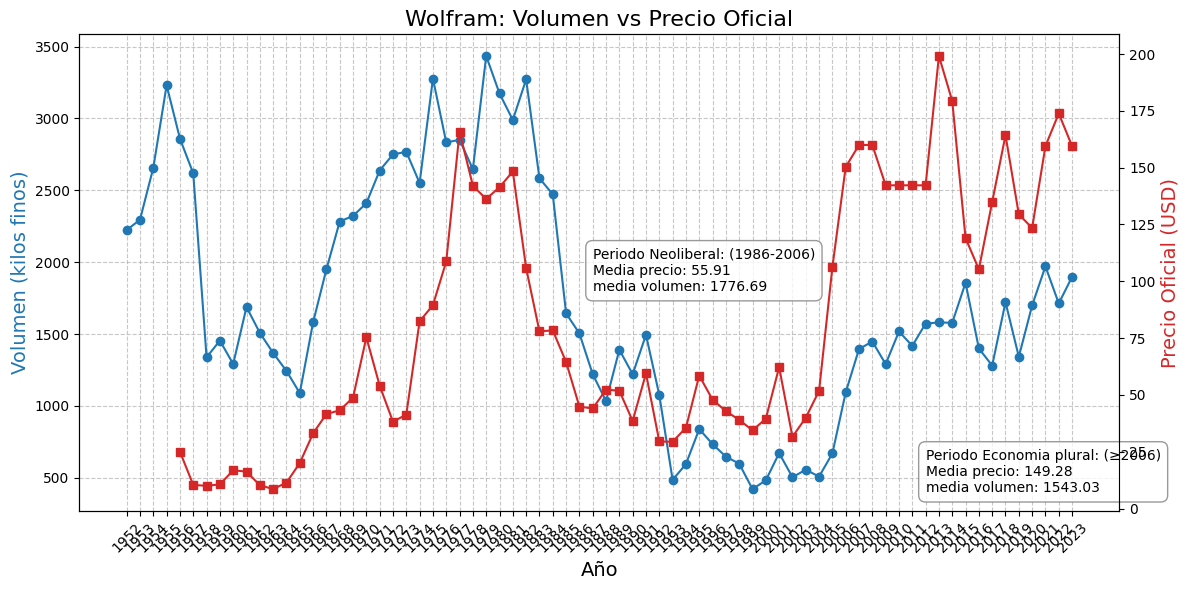

In [32]:
mineral="wolfram"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1987, 1800,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 400,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.5.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.5.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

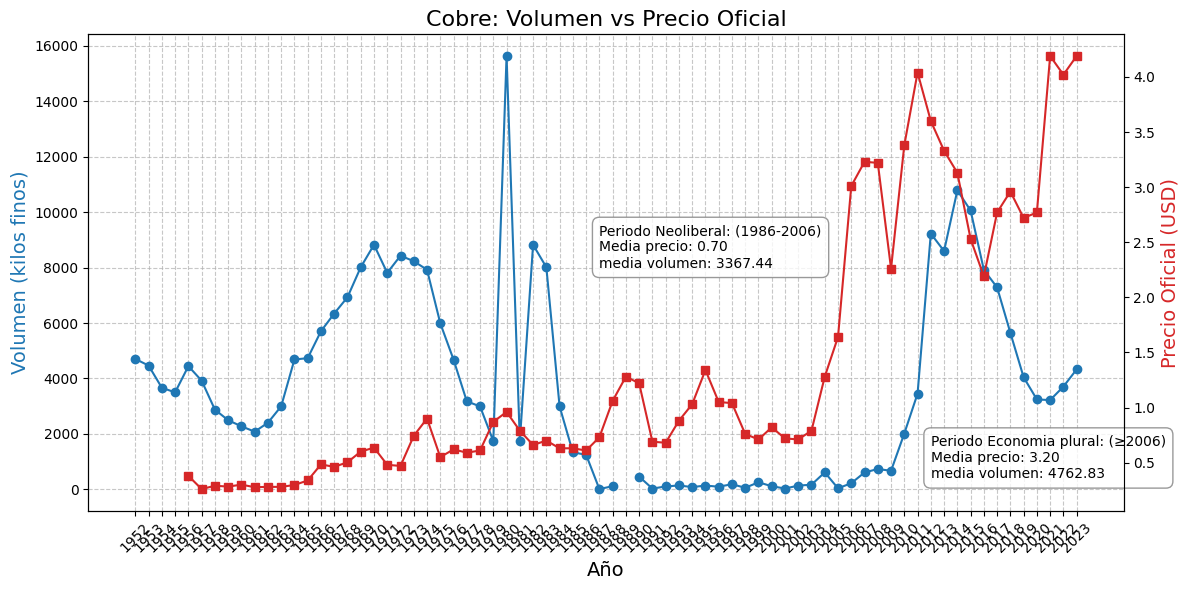

In [33]:
mineral="cobre"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1987, 8000,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 400,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.6.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.6.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

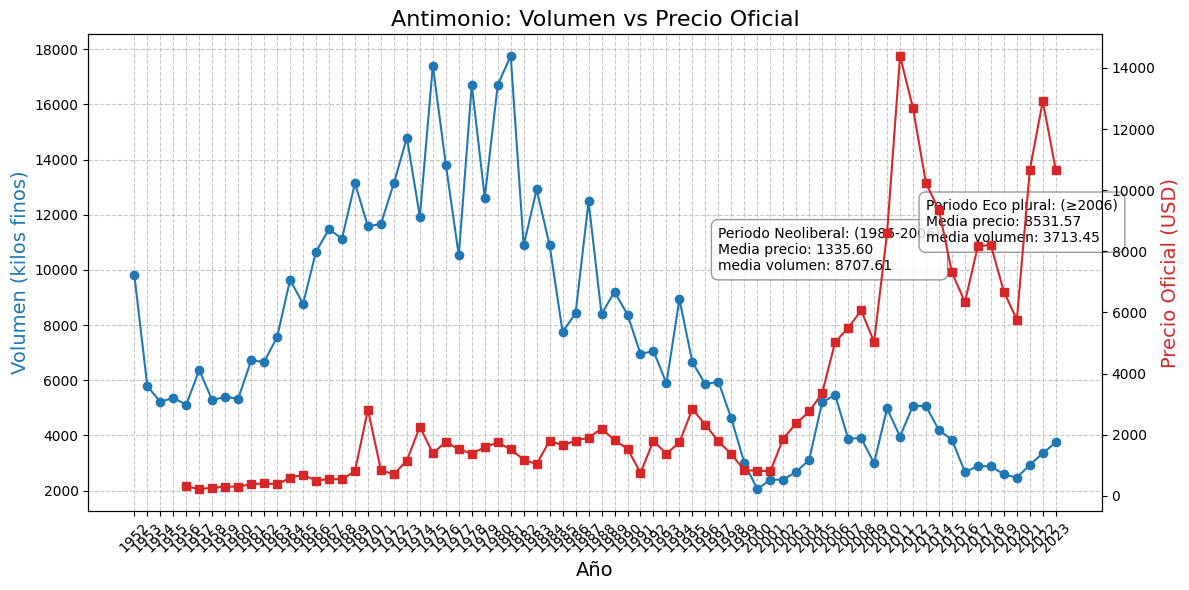

In [34]:
mineral="antimonio"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1997, 10000,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2013, 11000,
        f"Periodo Eco plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.7.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.7.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

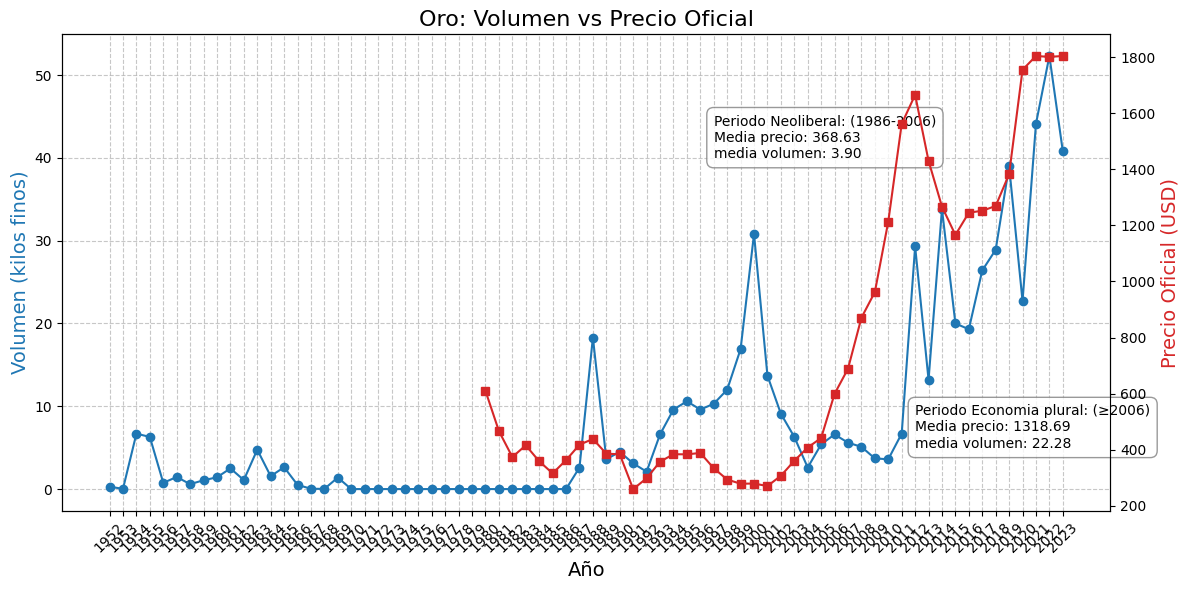

In [35]:
mineral="oro"
fig, ax1, promedio_precio_neolib, promedio_vol_neolib, promedio_precio_eco_plural, promedio_vol_eco_plural=dual_axis_grafica(df,df2,mineral)
ax1.text(1997, 40,
        f"Periodo Neoliberal: (1986-2006)\nMedia precio: {promedio_precio_neolib:.2f}\nmedia volumen: {promedio_vol_neolib:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))

ax1.text(2012, 5,
        f"Periodo Economia plural: (≥2006)\nMedia precio: {promedio_precio_eco_plural:.2f}\nmedia volumen: {promedio_vol_eco_plural:.2f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8))
plt.show()
filename_dual = os.path.join(output_dir, f"15.8.{mineral}_volumen_precio_oficial.png")
fig.savefig(filename_dual, dpi=300)
plt.close()

precio_efectivo_grafica(df,mineral)
filename_precio = os.path.join(output_dir, f"15.8.{mineral}_precio_efectivo.png")
plt.savefig(filename_precio, dpi=300)
plt.close()

In [36]:
# Factores de conversión
factor_lb = 1 / 0.453592   # Libras Finas a kilos
factor_ot = 1 / 0.0311035    # Onzas Troy a kilos
factor_tm = 1 / 1000         # Toneladas Métricas a kilos

# Conversión de precios oficiales a USD por kilo fino en df2
df2['zinc_kilo']      = df2['zinc'] * factor_lb
df2['estaño_kilo']    = df2['estaño'] * factor_lb
df2['plomo_kilo']     = df2['plomo'] * factor_lb
df2['cobre_kilo']     = df2['cobre'] * factor_lb
df2['wolfram_kilo']   = df2['wolfram'] * factor_lb
df2['oro_kilo']       = df2['oro'] * factor_ot
df2['plata_kilo']     = df2['plata'] * factor_ot
df2['antimonio_kilo'] = df2['antimonio'] * factor_tm





# --- Crear la aplicación Dash ---
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard de Exportaciones Minerales"),
    
    html.Div([
        html.Label("Selecciona un mineral:"),
        dcc.Dropdown(
            id="mineral-dropdown",
            options=[{"label": mineral.capitalize(), "value": mineral} for mineral in minerales_lista],
            value="zinc"
        )
    ], style={"width": "300px", "margin": "10px"}),

    html.Div(id="graphs-container"),
    html.Div(id="analysis-container", style={"margin-top": "20px", "fontSize": 16}),
    html.Div(id="graph-descriptions", style={"margin-top": "20px", "fontSize": 16}),
    html.Div(id="table-container", style={"margin-top": "20px", "fontSize": 16})
])

@app.callback(
    [Output("graphs-container", "children"),
     Output("analysis-container", "children"),
     Output("graph-descriptions", "children"),
     Output("table-container", "children")],
    [Input("mineral-dropdown", "value")]
)
def update_graphs(mineral):
    # Columnas específicas para el mineral seleccionado
    vol_col = f"{mineral}_volumen"
    precio_efectivo_col = f"{mineral}_precio_efectivo"
    valor_col = f"{mineral}_valor"  # valor exportado en miles de USD
    
    # Precio oficial convertido en df2
    official_price_col = f"{mineral}_kilo"

    # --- Gráfica Dual Axis: Volumen vs Precio Oficial ---
    trace_vol = go.Scatter(
        x=df.index,
        y=df[vol_col],
        mode="lines+markers",
        name="Volumen (kilos finos)",
        marker=dict(color='blue')
    )
    trace_price_official = go.Scatter(
        x=df2.index,
        y=df2[official_price_col],
        mode="lines+markers",
        name="Precio Oficial (USD)",
        marker=dict(color='red'),
        yaxis="y2"
    )
    layout_dual = go.Layout(
        title=f"{mineral.capitalize()}: Volumen vs Precio Oficial",
        xaxis=dict(title="Año"),
        yaxis=dict(title="Volumen (kilos finos)", titlefont=dict(color="blue")),
        yaxis2=dict(
            title="Precio Oficial (USD)",
            titlefont=dict(color="red"),
            overlaying="y",
            side="right"
        ),
        margin=dict(l=50, r=50, t=50, b=50)
    )
    dual_axis_fig = go.Figure(data=[trace_vol, trace_price_official], layout=layout_dual)

    # --- Gráfica de Precio Efectivo ---
    trace_pe = go.Scatter(
        x=df.index,
        y=df[precio_efectivo_col],
        mode="lines+markers",
        name="Precio Efectivo",
        marker=dict(color='green')
    )
    layout_pe = go.Layout(
        title=f"{mineral.capitalize()}: Precio Efectivo",
        xaxis=dict(title="Año"),
        yaxis=dict(title="Precio Efectivo (USD por unidad)"),
        margin=dict(l=50, r=50, t=50, b=50)
    )
    pe_fig = go.Figure(data=[trace_pe], layout=layout_pe)

    # --- Gráfica de Valor Exportado ---
    trace_valor = go.Scatter(
        x=df.index,
        y=df[valor_col] * 1000,  # Convertir de miles de USD a USD
        mode="lines+markers",
        name="Valor Exportado (USD)",
        marker=dict(color='purple')
    )
    layout_valor = go.Layout(
        title=f"{mineral.capitalize()}: Valor Exportado",
        xaxis=dict(title="Año"),
        yaxis=dict(title="Valor Exportado (USD)"),
        margin=dict(l=50, r=50, t=50, b=50)
    )
    valor_fig = go.Figure(data=[trace_valor], layout=layout_valor)

    graphs = html.Div([
        dcc.Graph(figure=dual_axis_fig),
        dcc.Graph(figure=pe_fig),
        dcc.Graph(figure=valor_fig)
    ])

    # --- Análisis Numérico Simple ---
    #periodo neoliberal
    price_contrib_neoliberalismo, volume_contrib_neoliberalismo=calc_contribuciones(df_period1,mineral)
    price_contrib_eco_plural, volume_contrib_eco_plural=calc_contribuciones(df_period2,mineral)
    analysis = html.Div([
        html.H3("Análisis Numérico del Crecimiento de Ingresos"),
        html.P(f"Período analizado: {df_period1.index.min()} a {df_period1.index.max()}."),
        html.P(f"Para {mineral.capitalize()}:"),
        html.Ul([
            html.Li(f"Contribución del precio: {price_contrib_neoliberalismo:.2f}%"),
            html.Li(f"Contribución del volumen: {volume_contrib_neoliberalismo:.2f}%")
        ]),
        
        html.P(f"Período analizado: {df_period2.index.min()} a {df_period2.index.max()}."),
        html.Ul([
            html.Li(f"Contribución del precio: {price_contrib_eco_plural:.2f}%"),
            html.Li(f"Contribución del volumen: {volume_contrib_eco_plural:.2f}%")
        ]),
        html.P("Si la contribución del precio es mayor, el aumento de ingresos se debe principalmente a mejores precios. "
               "Si la contribución del volumen es mayor, se debe a un incremento en la cantidad exportada.")
    ])

    description_text = html.Div([
        html.H3("Descripción de las Gráficas"),
        html.P("La primera gráfica (dual axis) muestra en un mismo gráfico el volumen exportado (línea azul) y el precio oficial (línea roja) para el mineral seleccionado. "
               "Permite analizar la relación entre la cantidad exportada y la cotización del mercado."),
        html.P("La segunda gráfica presenta el precio efectivo, calculado como el valor exportado (convertido de miles de USD a USD) dividido por el volumen exportado (en kilos finos). "
               "Este indicador refleja el ingreso promedio obtenido por cada unidad exportada y ayuda a determinar si los ingresos aumentan por mejores precios o por mayor volumen."),
        html.P("La tercera gráfica muestra la evolución del valor exportado (en USD), permitiendo identificar cómo varían los ingresos totales a lo largo del tiempo.")
    ])
    
    # --- Tabla de Cambios Porcentuales ---
    # Calcular series para el mineral seleccionado
    revenue = df[valor_col] * 1000
    price = df[precio_efectivo_col]
    volume = df[vol_col]
    
    pct_revenue = revenue.pct_change() * 100
    pct_price = price.pct_change() * 100
    pct_volume = volume.pct_change() * 100
    
    df_pct = pd.DataFrame({
        'Año': df.index,
        'Pct Change Revenue': pct_revenue.round(2),
        'Pct Change Price': pct_price.round(2),
        'Pct Change Volume': pct_volume.round(2)
    })
    
    table = dash_table.DataTable(
        data=df_pct.to_dict('records'),
        columns=[{'name': col, 'id': col} for col in df_pct.columns],
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center'},
        page_size=30
    )
    
    return graphs, analysis, description_text, table

if __name__ == "__main__":
    app.run_server(port=8051, debug=True)

2.715203690033835
precio zinc:46.45958429072682
volumen zinc:53.54041570927317
0.8847678055494157
precio zinc:-16.011155988948406
volumen zinc:116.0111559889484
